In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib qt
%matplotlib inline

# Calibrating the Camera
images = glob.glob('camera_cal/calibration*.jpg')
objpoints = []
imgpoints = []
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
chess = []
for location in images:
    img = mpimg.imread(location)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    ret,corners = cv2.findChessboardCorners(gray,(9,6),None)
    
    if (ret == True):
        imgpoints.append(corners)
        objpoints.append(objp)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1],None,None)



In [2]:
# funciton for undistorting the image
def undistort(img):
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    return undst

# function for Perspective Transform
def warp(img,img_size): 
    src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 95],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 95]])
    
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    
    Transform = cv2.getPerspectiveTransform(src,dst)
    Warp = cv2.warpPerspective(img,Transform,img_size)
    
    # Inverse perspective transform to get back to original image
    Minv = cv2.getPerspectiveTransform(dst, src)
        
    return Warp,Minv

# function for gradient in x and y
def sobel(img,orient,kernel,thresh):
    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if (orient == 'x'):
        sobel_x = cv2.Sobel(gray,cv2.CV_64F, 1, 0, ksize = kernel)
    elif (orient == 'y'):
        sobel_x = cv2.Sobel(gray,cv2.CV_64F, 0, 1, ksize = kernel)
    
    abs_sobelx = np.absolute(sobel_x)
    scaled = np.uint8(255*abs_sobelx/np.max(abs_sobelx))    
    
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
 
    return binary_output

# function for gradient magnitude 
# not used in the main pipeline
def sobel_mag(img,kernel,thresh):
    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray,cv2.CV_64F, 1, 0, ksize = kernel)
    sobel_y = cv2.Sobel(gray,cv2.CV_64F, 0, 1, ksize = kernel)
    sobelxy = np.sqrt(np.square(sobel_x) + np.square(sobel_y))
   
    absv = np.absolute(sobelxy)
    scale = np.uint8(255*absv/np.max(absv))
    
    binary_output = np.zeros_like(scale)
    binary_output[(scale >= thresh[0]) & (scale <= thresh[1])] = 1
 
    return binary_output

# function for direction gradient
# not used in the main pipeline
def dir_gradient(img,kernel,thresh):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0, ksize = kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F, 0, 1, ksize = kernel)
     
    absx = np.absolute(sobelx)
    absy = np.absolute(sobely)
    
    gradient = np.arctan2(absy,absx)
    binary_output = np.zeros_like(gradient)
    binary_output[(gradient >= thresh[0]) & (gradient <= thresh[1])] = 1
    return binary_output

# function for LAB color channel
# Using only the B- channel in the pipeline 
def lab_thresh(img,thresh):
    lab = cv2.cvtColor(img,cv2.COLOR_RGB2LAB)
    l = lab[:,:,0]
    a = lab[:,:,1]
    b = lab[:,:,2]
    
    binary_output = np.zeros_like(b)
    binary_output[(b >= thresh[0]) & (b <= thresh[1])] = 1
 
    return binary_output

# function for getting the polynomial coefficients 
# Used only for the 1st frame of the video
def hist(binary_warped):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
    nwindows = 9
# Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
# Set the width of the windows +/- margin
    margin = 100
# Set minimum number of pixels found to recenter window
    minpix = 50
# Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

# Step through the windows one by one
    for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
    # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return (left_fit,right_fit)

# function for getting polynomial coefficients using the coefficients from previously obtained coefficients
# Used on the upcoming frames except the 1st frames
def next_frames(binary_warped,left_fit,right_fit):

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return (left_fit,right_fit)

# function for drawing on the images 
def draw(binary_warped,left_fit,right_fit,Minv,img_size,undst):
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_size[0], img_size[1])) 
# Combine the result with the original image
    result = cv2.addWeighted(undst, 1, newwarp, 0.3, 0)
    
#########
# Calculating the curvature and distance fro center
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/650 # meters per pixel in x dimension
   
    y_eval = np.max(ploty)
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    lane_center = np.absolute((img_size[0]//2)-(left_fitx[len(left_fitx)-1]+right_fitx[len(right_fitx)-1])//2)*xm_per_pix
    
    # center curvature by averaging left and right curvatures
    center_curvature = (left_curverad+right_curverad)/2

    to_print = "Center distance = "+str(lane_center)+"      Curvature = "+ str(center_curvature)
    font = cv2.FONT_HERSHEY_SIMPLEX
    result = cv2.putText(result, to_print, (50, 50), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
   
    return result


    

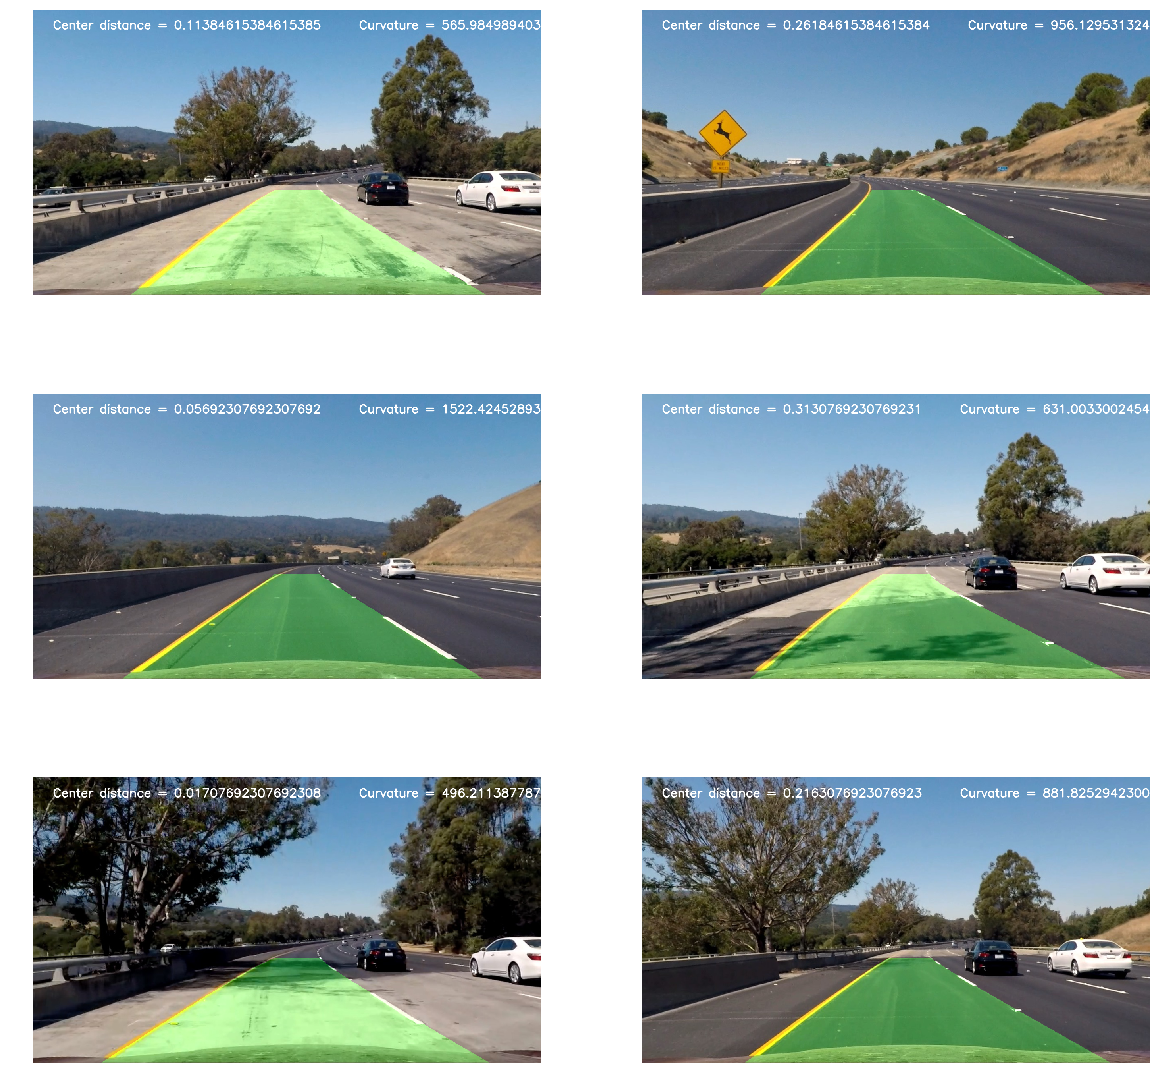

In [3]:
#######
## Testing on the Test_images provided by Udacity


test_images = glob.glob('test_images/test*.jpg')

plt.figure(figsize=(20,20))
counter = 1
counter1 = 0
left_fit,right_fit = ([],[])

for location in test_images:
    image = mpimg.imread(location)
    undst = undistort(image)

    gray = cv2.cvtColor(undst,cv2.COLOR_RGB2GRAY)
    img_size = (gray.shape[1],gray.shape[0])
    #print(img_size)
    
    lab = lab_thresh(undst,[150,255]) 
    sobelx = sobel(undst,'x',15,[30,130])
    
    combined_binary = np.zeros_like(sobelx)
    combined_binary[(lab == 1) | (sobelx == 1)] = 1

    binary_warped,Minv = warp(combined_binary,img_size)
     
    if (counter1 == 0):
        left_fit,right_fit = hist(binary_warped)
        warped = draw(binary_warped,left_fit,right_fit,Minv,img_size,undst)
        counter1 += 1
    else:
        left_fit,right_fit = next_frames(binary_warped,left_fit,right_fit)
        warped = draw(binary_warped,left_fit,right_fit,Minv,img_size,undst)     
             
    plt.subplot(3,2,counter)
    plt.imshow(warped,cmap = 'gray')
    plt.axis("off")
    counter+=1



In [5]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

counter2 = 0
left_fit,right_fit = ([],[]) # to globally store left and right lanes polynomial coefficients 

def process_image(image):
    
    undst = undistort(image)    # obtain undistorted image

    gray = cv2.cvtColor(undst,cv2.COLOR_RGB2GRAY)   
    img_size = (gray.shape[1],gray.shape[0])  #store size of the image
    
    lab = lab_thresh(undst,[150,255])    # get the LAB threshold binary image
    sobelx = sobel(undst,'x',15,[30,130])  # get the gradientx binary image
    
    combined_binary = np.zeros_like(sobelx)  
    combined_binary[(lab == 1) | (sobelx == 1)] = 1   # combine both the binary images
    
    binary_warped,Minv = warp(combined_binary,img_size)   #Perspective transform on the binary image
    
    global counter2   
    global left_fit,right_fit
    
    if (counter2 == 0):
        left_fit,right_fit = hist(binary_warped)      # get histogram on 1st frame and get initial polynomial coefficients
        warped = draw(binary_warped,left_fit,right_fit,Minv,img_size,undst)  # draw using the coefficents 
        counter2 += 1        # to differentiate between 1st and other frames
    else:
        left_fit,right_fit = next_frames(binary_warped,left_fit,right_fit)   #  get polynomial coefficients on next frames
        warped = draw(binary_warped,left_fit,right_fit,Minv,img_size,undst)     
    return warped
    

In [6]:
white_output = 'output/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video output/project_video.mp4
[MoviePy] Writing video output/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:35<00:00,  6.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_video.mp4 

Wall time: 3min 37s


In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))